In [1638]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [1639]:
# today's date string for file naming automation
# today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
today_date_str = '_2024-03-06.csv'

print(today_date_str)

_2024-03-06.csv


In [1640]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1739 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,MSFT,Microsoft Corporation,NASDAQ,2991865024204,USD,402.65,USD,404.48,USD,0.6500,USD,0.161431,0.454489,7318938817.36,26919177,44515133,159045,20043511.8,23220607.9,25412356.75555556,3.564297,1.77063671,1.45354449,405.846667,36.41683323,Technology Services,1.79896154,0.9529795,1.0291758,0.8906199,3.401715,3.425627,3.494110,2.72056179,1.32922035,0.80578435,1.06969419,1.36076495,0.42348812,0.11735635,420.82,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,402.85,USD,402.85,USD,402.85,USD,402.85,USD,402.85,USD,402.850,USD,414.25,USD,417.35,USD,417.35,USD,958891.40271493,USD,402.54800,402.401250,402.11602,401.572315,402.783991,402.094765,401.405539,402.652231,401.537350,400.422469
1,AAPL,Apple Inc.,NASDAQ,2626972696397,USD,170.12,USD,170.12,USD,1.2300,USD,0.723019,0.000000,15427863312.900002,95130377,176642456,612593,66996792.69999931,58859704.76666716,56051178.99999983,3.230751,1.66906114,1.51708484,170.593333,26.46958145,Electronic Technology,1.49335196,1.0467278,1.2041771,1.2891104,2.522859,3.033310,2.824503,2.05213039,0.88991179,0.4992566,0.75494684,1.51360234,0.68559221,0.20996954,191.05,USD,199.62,USD,199.62,USD,199.62,USD,199.62000,USD,170.22,USD,170.22,USD,170.22,USD,170.22,USD,170.22,USD,170.475,USD,172.04,USD,176.90,USD,180.53,USD,2380652.17391304,USD,170.10646,170.077787,170.07316,170.056969,170.201350,170.059595,169.917840,170.172883,170.033155,169.893427
2,NVDA,NVIDIA Corporation,NASDAQ,2149100036621.0005,USD,859.64,USD,864.16,USD,21.3600,USD,2.484761,0.525802,2399492500,52063600,113625575,972450,57962511.4,52115201.89999998,45803691.3777779,3.212762,3.2012168,3.80491577,851.593367,72.01776065,Electronic Technology,1.14108363,1.8023118,2.3419523,1.7245569,2.791819,2.878140,2.690679,1.66982475,0.67625101,0.40068698,0.66580538,0.87056351,0.50777842,0.16051256,876.95,USD,876.95,USD,876.95,USD,876.95,USD,876.95000,USD,860.00,USD,860.00,USD,860.00,USD,860.00,USD,860.00,USD,860.000,USD,860.97,USD,876.95,USD,876.95,USD,2058175.67567568,USD,859.27600,858.271250,854.95300,851.372692,861.148021,855.030130,848.912239,857.266897,850.172170,843.077443
3,AMZN,"Amazon.com, Inc.",NASDAQ,1808650704515.0005,USD,174.12,USD,174.88,USD,1.4499,

In [1641]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [1642]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,2.991865e+12,USD,402.65,USD,404.48,USD,0.6500,USD,0.161431,0.454489,7318938817.36,26919177,44515133,159045,20043511.8,23220607.9,25412356.75555556,3.564297,1.77063671,1.45354449,405.846667,36.41683323,Technology Services,1.79896154,0.9529795,1.0291758,0.8906199,3.401715,3.425627,3.494110,2.72056179,1.32922035,0.80578435,1.06969419,1.36076495,0.42348812,0.11735635,420.82,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,402.85,USD,402.85,USD,402.85,USD,402.85,USD,402.85,USD,402.850,USD,414.25,USD,417.35,USD,417.35,USD,958891.40271493,USD,402.54800,402.401250,402.11602,401.572315,402.783991,402.094765,401.405539,402.652231,401.537350,400.422469,Titans
1,AAPL,Apple Inc.,NASDAQ,2.626973e+12,USD,170.12,USD,170.12,USD,1.2300,USD,0.723019,0.000000,15427863312.900002,95130377,176642456,612593,66996792.69999931,58859704.76666716,56051178.99999983,3.230751,1.66906114,1.51708484,170.593333,26.46958145,Electronic Technology,1.49335196,1.0467278,1.2041771,1.2891104,2.522859,3.033310,2.824503,2.05213039,0.88991179,0.4992566,0.75494684,1.51360234,0.68559221,0.20996954,191.05,USD,199.62,USD,199.62,USD,199.62,USD,199.62000,USD,170.22,USD,170.22,USD,170.22,USD,170.22,USD,170.22,USD,170.475,USD,172.04,USD,176.90,USD,180.53,USD,2380652.17391304,USD,170.10646,170.077787,170.07316,170.056969,170.201350,170.059595,169.917840,170.172883,170.033155,169.893427,Titans
2,NVDA,NVIDIA Corporation,NASDAQ,2.149100e+12,USD,859.64,USD,864.16,USD,21.3600,USD,2.484761,0.525802,2399492500,52063600,113625575,972450,57962511.4,52115201.89999998,45803691.3777779,3.212762,3.2012168,3.80491577,851.593367,72.01776065,Electronic Technology,1.14108363,1.8023118,2.3419523,1.7245569,2.791819,2.878140,2.690679,1.66982475,0.67625101,0.40068698,0.66580538,0.87056351,0.50777842,0.16051256,876.95,USD,876.95,USD,876.95,USD,876.95,USD,876.95000,USD,860.00,USD,860.00,USD,860.00,USD,860.00,USD,860.00,USD,860.000,USD,860.97,USD,876.95,USD,876.95,USD,2058175.67567568,USD,859.27600,858.271250,854.95300,851.372692,861.148021,855.030130,848.912239,857.266897,850.172170,843.077443,Titans
3,AMZN,"Amazon.com, Inc.",NASDAQ,1.808651e+12,USD,174.12,U

In [1643]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [1644]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1739 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Large caps,413,23.749281
1,Small caps,390,22.426682
2,Midlers,372,21.391604
3,Shrimp,257,14.778608
4,Micro caps,254,14.606095
5,Titans,37,2.127660
6,Undefined,16,0.920069


In [1645]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1723 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
1111,FPI,Farmland Partners Inc.,NYSE,5.331157e+08,USD,11.1000,USD,10.76,USD,0.1500,USD,1.351351,-3.063063,43369501.1148,342561,688738,600,392269.2,361815.26666667,445963.43333333,2.796572,3.44443608,2.65345129,11.193333,24.08854167,Finance,0.78885962,1.1781658,0.7967418,0.77212423,3.777824,3.495274,4.191603,4.00300887,1.65973914,0.83066152,0.76267258,0.83805066,0.41298965,0.14030668,11.87,USD,13.12,USD,13.12,USD,13.27,USD,16.430000,USD,11.1100,USD,11.12,USD,11.12,USD,11.12,USD,11.12,USD,11.2500,USD,11.3950,USD,11.5500,USD,11.8200,USD,2210230.76923077,USD,11.10500,11.105625,11.11100,11.106923,11.123198,11.108750,11.094302,11.147265,11.115500,11.083735,Small caps
850,NVCR,NovoCure Limited,NASDAQ,1.745623e+09,USD,16.3000,USD,16.35,USD,0.0500,USD,0.306748,0.306748,96255402.586,544558,1244306,100,1132965.3,1075512.63333333,1339624.06666667,3.366584,5.4089226,6.25056494,16.306667,-,Health Technology,0.47606337,1.6278242,0.481096,0.41042212,3.208924,4.800527,4.545986,3.05865561,1.37625941,0.62871522,0.49170486,0.45654988,0.19953446,0.06888106,17,USD,17,USD,20.74,USD,83.6,USD,232.760000,USD,16.3400,USD,16.34,USD,16.34,USD,16.34,USD,16.34,USD,16.5500,USD,16.5800,USD,16.5825,USD,16.5825,USD,350542.32622161,USD,16.29398,16.299025,16.29600,16.287946,16.327763,16.288610,16.249457,16.436435,16.321165,16.205895,Small caps
1686,FLJ,FLJ Group Limited,NASDAQ,3.151952e+06,USD,0.6664,USD,0.72,USD,0.0136,USD,2.040816,8.043217,4301611.41213967,189873,290235,1472,174613.6,218269.6,545615.57777778,15.861345,13.17271528,14.73525667,0.701633,-,Finance,0.80799191,-2.557302,-1.6860957,-1.1045039,1.754899,2.209367,3.406324,0.95313662,0.873979,0.30421079,0.77194963,0.9810302,0.08275844,0.12341754,1.25,USD,4.95,USD,16.28,USD,60,USD,4087.580000,USD,0.6765,USD,0.69,USD,0.70,USD,0.70,USD,0.70,USD,0.7255,USD,0.7721,USD,0.8001,USD,0.8700,USD,0,USD,0.67083,0.678281,0.68938,0.690192,0.720962,0.689778,0.658593,0.723222,0.696507,0.669792,Shrimp
340,K,Kellanova,NYSE,1.819903e+10,USD,53.4200,USD,53.63,USD,0.0400,USD,0.074878,0.393111,285532452.14,3050967,7983988,6243,2991259.4,3053876,2779676.06666667,1.256564,1.60311471,2.10708941,53.576667,19.37753918,Consumer

In [1646]:
# # drop undefined
# tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

# market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

# market_cap_type_df2
# print(market_cap_type_df2)


In [1647]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [1648]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1723
Number of rows removed: 1711
NEW DataFrame length: 12


In [1649]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Large caps,5,41.666667
1,Midlers,4,33.333333
2,Small caps,2,16.666667
3,Titans,1,8.333333


In [1650]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Titans' 'Large caps' 'Midlers' 'Small caps']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'R

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,COST,Costco Wholesale Corporation,NASDAQ,3.372114e+11,USD,759.95,USD,764.81,USD,5.39,USD,0.709257,0.639516,4.416039e+08,2353351,4486705,7152,1870259.8,1924204.16666667,2055289.41111111,1.634298,1.439577,1.267966,762.040000,51.82454872,Retail Trade,1.440777,0.646755,1.0365967,0.7653925,3.965740,4.155118,3.959101,2.88393967,1.3260042,0.75912065,0.94496841,1.254680,0.4983195,0.15716356,769.27,USD,769.27,USD,769.27,USD,769.27,USD,769.2700,USD,760.6899,USD,760.6899,USD,760.6899,USD,760.6899,USD,760.6899,USD,765.3600,USD,769.2700,USD,769.2700,USD,769.2700,USD,766740.50632911,USD,760.204,759.813425,758.83772,759.516431,760.713309,758.902680,757.092051,764.206943,760.550985,756.895027,Titans
1,LRCX,Lam Research Corporation,NASDAQ,1.262653e+11,USD,963.10,USD,972.00,USD,13.20,USD,1.370574,0.924099,1.303891e+08,1308328,2209953,2869,914883.6,1123711.36666667,1014679.3,2.846938,2.393549,2.686010,964.666667,37.23593455,Producer Manufacturing,1.129054,1.6386241,1.7224767,1.5171801,2.370672,3.118617,7.212501,5.14443337,2.28528193,1.03282744,1.09206075,1.465169,0.45925903,0.1419295,993.86,USD,993.86,USD,993.86,USD,993.86,USD,993.8600,USD,964.0999,USD,964.0999,USD,964.0999,USD,964.0999,USD,964.0999,USD,964.0999,USD,979.0000,USD,993.8600,USD,993.8600,USD,1013180.58139535,USD,962.966,962.093750,959.82202,956.080746,964.375678,959.638255,954.900832,962.121713,956.141235,950.160757,Large caps
2,VEEV,Veeva Systems Inc.,NYSE,3.568751e+10,USD,221.64,USD,222.08,USD,0.44,USD,0.198520,0.198520,1.466126e+08,1646396,2871446,117,1204801.4,998142.33333333,1217116.34444444,2.970189,2.940872,2.282509,222.194533,68.87079734,Technology Services,1.174330,1.5782332,1.0053954,0.7411759,2.252674,6.553840,5.118202,2.58780803,1.31214752,0.59013974,0.63051315,1.450122,0.63111429,0.23688819,230.655,USD,230.655,USD,230.655,USD,230.655,USD,343.9600,USD,222.3400,USD,222.4400,USD,222.4400,USD,222.4400,USD,222.4400,USD,223.6500,USD,225.4626,USD,226.5000,USD,230.6550,USD,-,-,221.993,222.005000,221.64500,221.142692,222.337662,221.714250,221.090838,222.343263,221.298000,220.252737,Large caps
3,TTWO,"Take-Two Interactive Software, Inc.",NASDAQ,2.455421e+10,USD,143.94,USD

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [1651]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [1652]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [1653]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [1654]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 12/12 [00:00<00:00, 1660.89it/s]


In [1655]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-10-16
END date: 2024-03-13
103 days of historical stock data.

1133 = Length of dataframe
11 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['COST', 'LRCX', 'VEEV', 'TTWO', 'FNV', 'ELF', 'MTN', 'AVAV', 'TCBI', 'SOVO', 'MCB', 'CSTR']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
1123,18.75,19.0000,18.61,18.90,2024-02-29,CSTR,72566,HISTORICAL_PRICES,CSTR,,2024-02-29,1709258427000,0.266892,0.266892,18.90,18.75,19.0000,18.61,72566,18.90,18.75,19.0000,18.61,72566,"Feb 29, 24",0.31,0.0168,CSTR
1124,18.66,18.7700,18.22,18.77,2024-03-01,CSTR,62200,HISTORICAL_PRICES,CSTR,,2024-03-01,1709350245000,0.260811,0.260811,18.77,18.66,18.7700,18.22,62200,18.77,18.66,18.7700,18.22,62200,"Mar 1, 24",-0.09,-0.0048,CSTR
1125,18.54,18.9600,18.53,18.79,2024-03-04,CSTR,72545,HISTORICAL_PRICES,CSTR,,2024-03-04,1709604036000,0.252703,0.252703,18.79,18.54,18.9600,18.53,72545,18.79,18.54,18.9600,18.53,72545,"Mar 4, 24",-0.12,-0.0064,CSTR
1126,19.29,19.4100,18.50,18.55,2024-03-05,CSTR,153529,HISTORICAL_PRICES,CSTR,,2024-03-05,1709692278000,0.303378,0.303378,18.55,19.29,19.4100,18.50,153529,18.55,19.29,19.4100,18.50,153529,"Mar 5, 24",0.75,0.0405,CSTR
1127,19.28,19.5391,18.77,19.43,2024-03-06,CSTR,115087,HISTORICAL_PRICES,CSTR,,2024-03-06,1709776876000,0.302703,0.302703,19.43,19.28,19.5391,18.77,115087,19.43,19.28,19.5391,18.77,115087,"Mar 6, 24",-0.01,-0.0005,CSTR
1128,19.30,19.5800,19.22,19.41,2024-03-07,CSTR,94999,HISTORICAL_PRICES,CSTR,,2024-03-07,1709863230000,0.304054,0.304054,19.41,19.30,19.5800,19.22,94999,19.41,19.30,19.5800,19.22,94999,"Mar 7, 24",0.02,0.0010,CSTR
1129,19.33,19.6200,19.30,19.62,2024-03-08,CSTR,83694,HISTORICAL_PRICES,CSTR,,2024-03-08,1709951445000,0.306081,0.306081,19.62,19.33,19.6200,19.30,83694,19.62,19.33,19.6200,19.30,83694,"Mar 8, 24",0.03,0.0016,CSTR
1130,19.33,19.4600,19.21,19.36,2024-03-11,CSTR,38283,HISTORICAL_PRICES,CSTR,,2024-03-11,1710230497000,0.306081,0.306081,19.36,19.33,19.4600,19.21,38283,19.36,19.33,19.4600,19.21,38283,"Mar 11, 24",0.00,0.0000,CSTR
1131,19.08,19.3800,19.00,19.20,2024-03-12,CSTR,51188,HISTORICAL_PRICES,CSTR,,2024-03-12,1710297077000,0.289189,0.289189,19.20,19.08,19.3800,19.00,51188,19.20,19.08,19.3800,19.00,51188,"Mar 12, 24",-0.25,-0.0129,CSTR
1132,19.10,19.2800,18.96,18.96,2024-03-13,CSTR,146601,HISTORICAL_PRICES,CSTR,,2024-03-13,1710381627000,0.290541,0.290541,18.96,19.10,19.2800,18.96,146601,18.96,19.10,19.2800,18.96,146601,"Mar 13, 24",0.02,0.0010,CSTR


In [1656]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [1657]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,AVAV,2024-03-13,161.21,162.58,159.650,160.83,231079
1,COST,2024-03-13,734.20,736.50,726.580,735.00,2270262
2,CSTR,2024-03-13,19.10,19.28,18.960,18.96,146601
3,ELF,2024-03-13,206.42,209.72,203.646,204.99,827282
4,FNV,2024-03-13,116.19,116.24,112.820,113.44,882849
5,LRCX,2024-03-13,926.71,940.70,920.905,937.01,1008188
6,MCB,2024-03-13,38.73,39.74,38.480,38.92,101412
7,MTN,2024-03-13,221.49,230.60,221.130,227.56,482868
8,TCBI,2024-03-13,59.19,60.11,58.955,59.15,292228
9,TTWO,2024-03-13,144.89,146.69,144.120,144.53,1371044


In [1658]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 1133


In [1659]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [1660]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,COST,2023-10-16,572.24,574.097,568.520,569.69,1428517
618,MTN,2023-10-16,222.71,223.570,216.910,217.50,413399
515,ELF,2023-10-16,103.70,104.170,100.060,102.59,1056245
1030,CSTR,2023-10-16,14.80,14.925,14.420,14.78,114068
103,LRCX,2023-10-16,650.70,655.630,644.117,647.82,998984


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [1661]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-10-16,COST,572.24,574.097,568.520,569.69,1428517
2023-10-16,MTN,222.71,223.570,216.910,217.50,413399
2023-10-16,ELF,103.70,104.170,100.060,102.59,1056245
2023-10-16,CSTR,14.80,14.925,14.420,14.78,114068
2023-10-16,LRCX,650.70,655.630,644.117,647.82,998984


| TICKER - Unit TESTING | 
|-|

In [1662]:
# filter by symbol
ticker = 'MTN'
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

# dtype of index
print(ticker_df.index.dtype)

ticker_df.tail(10)

datetime64[ns]


,symbol,close,high,low,open,volume
date,,,,,,
2024-02-29,MTN,230.31,231.51,229.2900,230.66,516867
2024-03-01,MTN,230.55,230.92,227.3000,230.00,381129
2024-03-04,MTN,217.93,229.46,216.0400,229.46,865326
2024-03-05,MTN,219.06,221.91,215.7400,218.22,548142
2024-03-06,MTN,228.71,235.81,228.0700,230.19,1020082
2024-03-07,MTN,226.08,229.34,225.5300,229.08,461507
2024-03-08,MTN,223.76,225.79,218.1500,221.90,720663
2024-03-11,MTN,224.63,228.90,224.2401,224.55,678324
2024-03-12,MTN,226.25,229.44,215.0000,215.00,1004957


In [1663]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-02-29,MTN,230.31,231.51,229.2900,230.66,516867
2024-03-01,MTN,230.55,230.92,227.3000,230.00,381129
2024-03-04,MTN,217.93,229.46,216.0400,229.46,865326
2024-03-05,MTN,219.06,221.91,215.7400,218.22,548142
2024-03-06,MTN,228.71,235.81,228.0700,230.19,1020082
2024-03-07,MTN,226.08,229.34,225.5300,229.08,461507
2024-03-08,MTN,223.76,225.79,218.1500,221.90,720663
2024-03-11,MTN,224.63,228.90,224.2401,224.55,678324
2024-03-12,MTN,226.25,229.44,215.0000,215.00,1004957


| DATA PACKAGE |
|-|
| Trend Lines |


In [1664]:
# Step 1: Extract the last 72 closing prices
last_72_df = ticker_df[['Close']].tail(72)
last_72_df['Index'] = np.arange(len(ticker_df) - 72, len(ticker_df))

In [1665]:
# Step 2: Perform a linear regression
X = last_72_df['Index'].values.reshape(-1, 1)  # Reshape for scikit-learn
y = last_72_df['Close'].values
model = LinearRegression().fit(X, y)

In [1666]:
# Step 3: Calculate the y-values for the line of best fit for the last 72 periods
best_fit_last_72 = model.predict(X)

# Create a series for the best fit line, filled with NaN except for the last 72 values
best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
best_fit_series[-72:] = best_fit_last_72

In [1667]:
# Step 4: Pivot Points
pivot_point_low_index = last_72_df['Close'].idxmin()
pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

pivot_point_high_index = last_72_df['Close'].idxmax()
pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# Create a series for the pivot points, similar to the best fit line
pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
pivot_points_low[pivot_point_low_index] = pivot_point_low_value

pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
pivot_points_high[pivot_point_high_index] = pivot_point_high_value

In [1668]:
# step 5: chart setup
apds = [
    mpf.make_addplot(best_fit_series, color='orange', width=2),
    mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
    mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
]

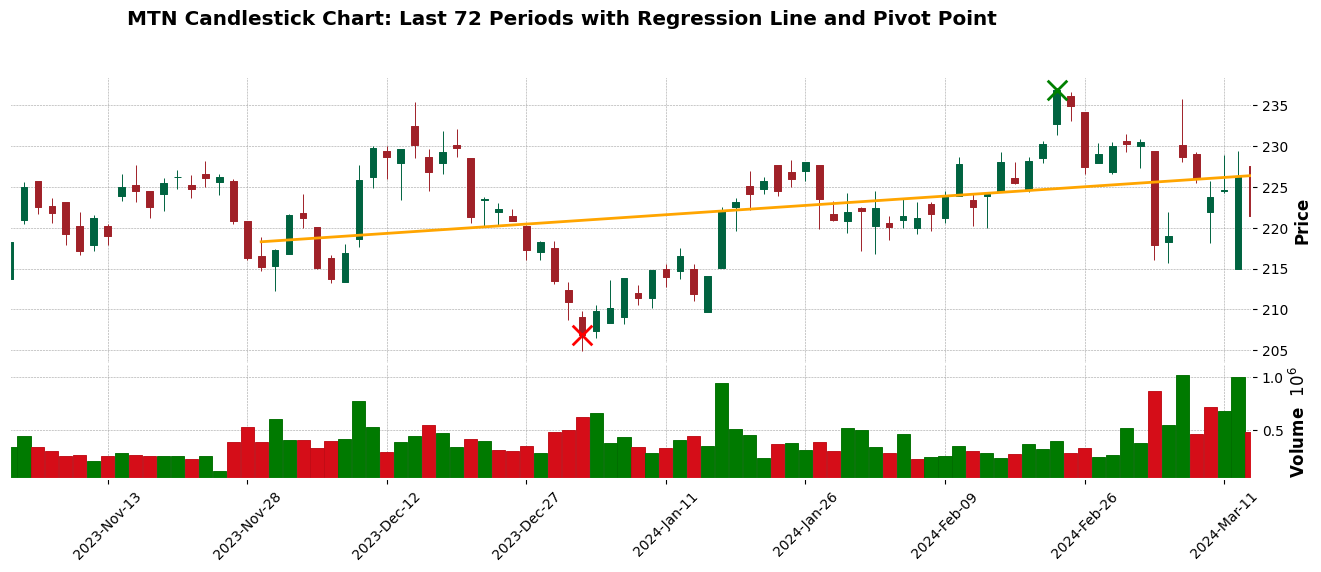

In [1669]:
# Step X: chart it
last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
         figratio=(42, 14),
         xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
         addplot=apds)

mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [1670]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [1671]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [1672]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [1673]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [1674]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [1675]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [1676]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [1677]:
# chart_historical_df.head(5)

In [1678]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [1679]:
# # date column check data type
# chart_historical_df.index

In [1680]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [1681]:
# chart_historical_df.index

In [1682]:
# chart_historical_df.head(5)

In [1683]:
# print(tv_L2_df.columns)

In [1684]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [1685]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [1686]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [1687]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [1688]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [1689]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [1690]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [1691]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [1692]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [1693]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [1694]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [1695]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| TREND LINES |
|-|
| Trend Lines Algorithm |

In [1696]:
# # check the date column type
# chart_historical_df.index

In [1697]:
# print(f'Unique stock symbols: {unique_symbols}')

In [1698]:
# tl_pre_df = chart_historical_df[chart_historical_df['symbol'] == 'GRND']
# tl_pre_df = tl_pre_df.iloc[:,:6]

# tl_pre_df.head(5)

In [1699]:
# # get the date column type
# tl_pre_df.index

In [1700]:

# tl_pre_df.reset_index(inplace=True)
# # save to .xlsx using xlwings
# tl_pre_file = f'tl_pre_file.xlsx'
# tl_pre_df.to_excel(tl_pre_file, index=False)

# # save df to csv
# tl_pre_df.to_csv(f'tl_pre_file.csv', index=False)
# # open the file in Excel
# # app = xw.App(visible=True)
# # book = app.books.open(tl_pre_file)

In [1701]:
# # convert to the datetime type
# tl_pre_df.index = pd.to_datetime(tl_pre_df.index)

# tl_pre_df.head(5)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [1702]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [1703]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [1704]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [1705]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [1706]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [1707]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [1708]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [1709]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)